To start, press "*Runtime*" and press "*Run all*" on the **free*** instance of the Tesla T4 Google Colab!

To install Unsloth on your computer, follow the installation instructions on our Github page [here](https://github.com/unslothai/unsloth#installation-instructions---conda ).

You will learn how to perform [data preparation](#Data), how to [Train](#Train), how to [run the model](#Inference) and [how to save it](#Save) (for example, for Llama.cpp ).

### Loading libraries

In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

### Loading the model

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# The name of the models to download
models = [
    "lightblue/suzume-llama-3-8B-multilingual-orpo-borda-half",
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/Qwen2-7B-Instruct-bnb-4bit",
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
] # Try more models at https://huggingface.co/models
n=2 # Select the model number
model_name = models[n].split('/')[1]
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = models[n], # support ANY Hugging Face model!
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.1: Fast Qwen2 patching. Transformers: 4.55.4.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### Model Modification Parameters LoRA (We now add LoRA adapters so we only need to update 1 to 10% of all parameters!)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 1,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.9.1 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


## Preparing a dataset for training

### Classification of groups

In [ ]:
import pandas as pd
import numpy as np

import requests
import os

# 10.5281/zenodo.17054610
record_id = '17054610'
filename_to_download = 'dataset_groups_delivery.xlsx'

api_url = f'https://zenodo.org/api/records/{record_id}'

try:
    print(f"Searching for file '{filename_to_download}' in Zenodo repository with ID: {record_id}...")

    response = requests.get(api_url)
    response.raise_for_status()
    data = response.json()

    file_url = None
    for file in data.get('files', []):
        if file.get('key') == filename_to_download:
            file_url = file.get('links', {}).get('self')
            break

    if file_url:
        print(f"File '{filename_to_download}' found. Starting download...")

        file_response = requests.get(file_url, stream=True)
        file_response.raise_for_status()

        # Save the file to the current directory
        with open(filename_to_download, 'wb') as f:
            for chunk in file_response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"File '{filename_to_download}' downloaded successfully.")
    else:
        print(f"File '{filename_to_download}' not found in the repository.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred while accessing Zenodo: {e}")

posts = pd.read_excel('vk_groups_dataset.xlsx')
# Replacing NaN values with empty strings
posts = posts.fillna('')

# Converting all columns to a string type
posts['Признак'] = posts['Признак'].astype(str)
posts['Название Описание'] = posts['Название'].astype(str) + posts['Описание'].astype(str)
posts['Название Описание'] = posts['Название Описание'].astype(str)
posts['Instruction'] = """
        You are an expert in analyzing companies and groups in the field of
        food delivery. You will be given groups with a name and a description
        (there may be no description). Your task is to determine if this group
        meets the criteria. food delivery services. Just answer '1' if it's a
        food delivery, '0' if it's not.
    """

def split_dataframe(dataframe, test_proportion):
    total_size = len(dataframe)
    test_size = int(total_size * test_proportion)
    indices = np.arange(total_size)
    np.random.shuffle(indices)
    train_indices = indices[0:total_size-test_size]
    test_indices = indices[total_size - test_size:]
    return dataframe.iloc[train_indices], dataframe.iloc[test_indices]

train, test = split_dataframe(posts, 0.3)

from datasets import Dataset
ds = Dataset.from_dict({
    "output": train['Признак'],
    "input": train['Название Описание'],
    'instruction':train['Instruction']
    })
ds[0]

{'output': '0',
 'input': 'фотографияФотосъемка с детальным подходом к каждому.Создание образа,макияжа, подборка места.\n',
 'instruction': "\n        You are an expert in analyzing companies and groups in the field of\n        food delivery. You will be given groups with a name and a description\n        (there may be no description). Your task is to determine if this group\n        meets the criteria. food delivery services. Just answer '1' if it's a\n        food delivery, '0' if it's not.\n    "}

### Converting a dataset to a suitable format

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = ds
dataset = dataset.map(formatting_prompts_func, batched = True,)

## Model training


In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported
import os
os.environ["WANDB_DISABLED"] = "true"

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,

        # Use num_train_epochs = 1, warmup_ratio for full training runs!
        warmup_steps = 5,
        max_steps = 60,

        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 5,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
#@title Indicators of available video memory
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
6.725 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 8,130 | Num Epochs = 1 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 40,370,176 of 7,655,986,688 (0.53% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,2.190400
10,1.695300
15,1.151900
20,1.165800
25,1.275800
30,1.180400
35,1.117900
40,1.043700
45,1.069900
50,1.072500


In [ ]:
#@title Video memory usage indicators and statistics
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

578.5464 seconds used for training.
9.64 minutes used for training.
Peak reserved memory = 8.359 GB.
Peak reserved memory for training = 1.634 GB.
Peak reserved memory % of max memory = 56.706 %.
Peak reserved memory for training % of max memory = 11.085 %.



## Launching the model

### Classification of groups

In [ ]:
import re

post_result = []
for  class_post, text, Instruction in test[['Признак','Название Описание','Instruction']].itertuples(index=False, name=None):
    # alpaca_prompt = Copied from above
    FastLanguageModel.for_inference(model) # Unsloth has 2x faster inference!
    inputs = tokenizer(
    [
        alpaca_prompt.format(
            Instruction, # instruction
            text, # input
            "", # output - leave this blank for generation!
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    message_answer =tokenizer.batch_decode(outputs)[0].rsplit('Response:', 1)[-1]
    match = re.search(r'[01]', message_answer)
    if match:
        post_result.append(int(match.group()))
    else:
        post_result.append(-1)
#post_result

In [ ]:
test["Ответ"] = post_result
df=test

# model_name="gte-Qwen2-7B-instruct"
df.to_excel(model_name+'_output.xlsx', index=False)
df.to_csv(model_name+"_output.csv", index=False)

df['Признак'] = df['Признак'].astype(int)
df_difference = df.loc[df['Признак'] != df["Ответ"]]
#print(df_difference)
test.info()
df_difference.info()
df_difference.to_excel(model_name+'_difference.xlsx', index=False)
df_difference.to_csv(model_name+'_difference.csv')

/tmp/ipython-input-4239922657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Ответ"] = post_result
/tmp/ipython-input-4239922657.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Признак'] = df['Признак'].astype(int)


<class 'pandas.core.frame.DataFrame'>
Index: 3483 entries, 3594 to 235
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID_группы          3483 non-null   int64 
 1   Название           3483 non-null   object
 2   ID_города          3483 non-null   object
 3   Город              3483 non-null   object
 4   Описание           3483 non-null   object
 5   Признак            3483 non-null   int64 
 6   Название Описание  3483 non-null   object
 7   Instruction        3483 non-null   object
 8   Answer             3483 non-null   int64 
 9   Ответ              3483 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 299.3+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 6330 to 9394
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID_группы          146 non-null    int64 
 1   Название           146 non-nul

Model Accuracy: 0.9581

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1775
           1       0.94      0.98      0.96      1708

    accuracy                           0.96      3483
   macro avg       0.96      0.96      0.96      3483
weighted avg       0.96      0.96      0.96      3483



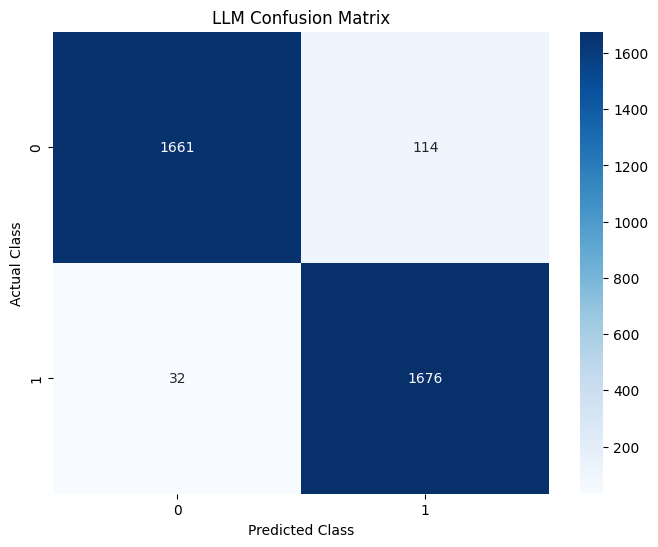

Number of incorrect predictions: 146


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

test.loc[:, 'Answer'] = post_result

true_labels = test['Признак'].astype(int)

predicted_labels = test['Answer']

# --- Metrics Calculation and Reporting ---

# 1. Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Model Accuracy: {accuracy:.4f}\n")

# 2. Classification Report (Precision, Recall, F1-score)
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 3. Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LLM Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# You can still save the dataframe with differences if you wish
df_difference = test[test['Признак'] != test["Answer"]]
print(f"Number of incorrect predictions: {len(df_difference)}")